# Sentiment analysis with Finnish AFINN models
#### - Hate Speech (HS) binary labels (0, 1) as 'no HS' and 'HS'
#### - For HS dataset of 'raw' and 'corrected' samples
#### - Parsing, preprocessing and AFINN based classification

### This script was published as a part of research work
This script was created and published by Merja Kreivi-Kauppinen.

This script is part of research work carried at University of Oulu in 2020-2023.

Topic of research work and thesis:
'Signs of Paradigm Shift in Hate Speech Detection Methodology: Hate Speech Detection of Dialectal, Granular and Urban Finnish'


### Method of sentiment analysis

HS binary classification with afinn SA was carried on lemmatized samples, where only original and lemma words were used to get sentiment scoring for text samples. Emoticons and emojis were not taken into account in sentiment scoring.

Text samples were lemmatized with experimental Finnish Voikko method designed for Spacy (Spacy version 3.5.0) using large Finnish language model 'fi_core_news_lg' the source of tokens.

Text samples were further tokenized with NLTK casual tokenization method, and set to lower capitals before feeding to afinn scoring process.

Samples which sum of scores were above zero got prediction label '1' indicated the 'HS' label, samples which got zero '0' as sentiment scoring value indicated 'not HS' label.

Scoring was carried for 'raw' text samples and manually 'corrected' text samples.

Results were analyzed with methods of scikit-learn library by calculating confusion matrix, and accuracy, F1, precision and recall scores for binary classifier.

### Original afinn available in GitHub
Original version of Afinn method available at GitHub: https://github.com/fnielsen/afinn 
 - Reference:
Finn Årup Nielsen, "A new ANEW: evaluation of a word list for sentiment analysis in microblogs", 
Proceedings of the ESWC2011 Workshop on 'Making Sense of Microposts': 
Big things come in small packages. Volume 718 in CEUR Workshop Proceedings: 93-98. 2011 May. 
Matthew Rowe, Milan Stankovic, Aba-Sah Dadzie, Mariann Hardey (editors)

### Finnish AFINN lexicon for binary classification of hate speech (HS)

Documentation of FINNfin library available as README.

Finnish AFINN for binary classification of hate speech (HS) uses lexicon which includes basic, pended, subword and lemma forms of words and their binary labels.

Each word is labeled with one sentiment label, where zero '0' presents 'no HS' label and one '1' presents 'HS' label.

Words were labeled as HS according to the list of 'Finnish hate speech search terms'. (Rauta 2018) 

Several different types of swearing, bullying, teasing, and insulting words and word forms were given HS label in order to detect HS typical on children sites.

Lexicon 'fin_afinn_HS_binary_MerjasList_2023' included 9990 word forms, where 9163 were labeled as 'not HS' (0) and 829 as 'HS' (1).

 - Reference: Rauta, J. (2018). Poliisin tietoon tullut viharikollisuus Suomessa 2017. Poliisiammattikorkeakoulun raportteja 131. 


### The original AFINN method was sligthly modified before application to binary classification

New script available at file AFINN_scores.py

Changes in original script.
The Original AFinn class was replaced with

    - AFinnEmoticons class,
    
    - AFinnWords class, and
    
    - AfinnEmojis class

The AFinnWords class was used with 'word_boundary=True' flag to enable more precise text matching.

The AFinnWords class includes small changes in script.

New flags were added to AFinnEmoticons and AFinnEmojos classes.
The AFinnEmoticons and AFinnEmojis classes can be used with 
'emoticons_only=True' or 'emoticons_only=True' flag 
to enable text sample matching with emoticons or emojis only.

     - AFinnEmoticons class has 'emoticons_only' flag
     
     - AFinnEmojis class has 'emojis only' flag


## Import and check  jupyter python installations, packages and libraries

In [1]:
# import python packages and libraries

import sys, re, os
import numpy as np
import pandas as pd
import string, math 
import time, datetime, random
print(f"\nPython Version: {sys.version} \n")

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams

# set seaborn figures
%matplotlib inline
rcParams['figure.figsize'] = 8, 4
sns.set(style='darkgrid', palette='muted', font_scale=1.0)


Python Version: 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)] 

The scikit-learn version is 1.1.2.


## Import NLP packages and AFINN for Finnish

In [2]:
import nltk
from nltk.tokenize import casual_tokenize, word_tokenize, sent_tokenize, WhitespaceTokenizer

# import Afinn form AFINNfin for Finnish 
import AFINNfin
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

import emoji
from emoji import *
import functools
import operator

## Import Experimental Spacy and Voikko

In [3]:
# Import and check Spacy
import spacy
print(f"Spacy Version: {spacy.__version__}")

# Load large Finnish model for spacy
FinSpacyLarge = spacy.load("fi_core_news_lg")

Spacy Version: 3.5.0


In [4]:
# Test large Finnish model

# Load large Finnish model
FinSpacyLarge = spacy.load("fi_core_news_lg")

# Test the model
doc = FinSpacyLarge('Terveyden ja hyvinvoinnin laitos (THL) johtaa hanketta. Ilmassa on kevättä. Rännit tippuvat ja katuojat juoksevat.')
for t in doc:
    print(f'{t.lemma_}\t{t.pos_}')

terveys	NOUN
ja	CCONJ
hyvinvointi	NOUN
laitos	NOUN
(	PUNCT
THL	NOUN
)	PUNCT
johtaa	VERB
hanke	NOUN
.	PUNCT
Ilmassa	NOUN
olla	AUX
kevät	NOUN
.	PUNCT
Rännit	NOUN
tippua	VERB
ja	CCONJ
katuoja	NOUN
juoksevat	VERB
.	PUNCT


In [5]:
from libvoikko import Voikko
print("\nCurrent working directory " , os.getcwd())


Current working directory  C:\Users\merja\Desktop\HS_research_project\AFINN_sentiment_analysis


In [6]:
# set up Voikko search path for Voikko help
Voikko.setLibrarySearchPath("c:/Voikko")
help(Voikko)

Help on class Voikko in module libvoikko:

class Voikko(builtins.object)
 |  Voikko(language, path=None)
 |  
 |  Represents an instance of Voikko. The instance has state, such as
 |  settings related to spell checking and hyphenation, and methods for performing
 |  various natural language analysis operations. One instance should not be
 |  used simultaneously from multiple threads.
 |  
 |  Methods defined here:
 |  
 |  __del__(self)
 |  
 |  __init__(self, language, path=None)
 |      Creates a new Voikko instance with the following optional parameters:
 |      language  BCP 47 language tag to be used.
 |      path      Extra path that will be checked first when looking for linguistic
 |                resources.
 |  
 |  analyze(self, word)
 |      Analyze the morphology of given word and return the list of
 |      analysis results. The results are represented as maps having property
 |      names as keys and property values as values.
 |  
 |  attributeValues(self, attributeName)

In [7]:
# get Voikko directory list
print("\nVoikko directory list:  ", Voikko.listDicts("C:/Voikko"))


Voikko directory list:   [<fi,,standard,suomi (perussanasto)>, <fi,,dialects,suomi (murteellisten, vanhojen ja harvinaisten sanojen sanasto)>, <fi,,education,suomi (kasvatustieteen sanasto)>, <fi,,medicine,suomi (matematiikan, fysiikan, kemian, biologian, maantieteen, geologian ja lääketieteen sanastot)>, <fi,,morpho,suomi, erittäin laaja sanasto (mukana myös morfologisessa analyysissä tarvittava lisäinformaatio)>, <fi,,morphoid,suomi, erittäin laaja sanasto (mukana myös morfologisessa analyysissä tarvittava lisäinformaatio ja linkitys Joukahaiseen)>, <fi,,po,suomi (po-tiedostojen oikolukusanasto)>, <fi,,science,suomi (matematiikan, fysiikan, kemian, biologian, maantieteen, geologian, lääketieteen, kasvatustieteen ja tietotekniikan sanastot)>]


In [8]:
# get Voikko version
print("Voikko version:  ", Voikko.getVersion())

Voikko version:   4.3


In [9]:
# Test experimental Finnish Spacy model with Spacy

# Load large Finnish model
FinSpacyExp = spacy.load("spacy_fi_experimental_web_md")

# Test the model
doc = FinSpacyExp('Terveyden ja hyvinvoinnin laitos (THL) johtaa hanketta. Ilmassa on kevättä. Rännit tippuvat ja katuojat juoksevat.')
for t in doc:
    print(f'{t.lemma_}\t{t.pos_}')

terveys	NOUN
ja	CCONJ
hyvinvointi	NOUN
laitos	NOUN
(	PUNCT
THL	PROPN
)	PUNCT
johtaa	VERB
hanke	NOUN
.	PUNCT
ilma	NOUN
olla	AUX
kevät	NOUN
.	PUNCT
ränni	NOUN
tippua	VERB
ja	CCONJ
katuoja	NOUN
juosta	VERB
.	PUNCT


# Testing AFINN scoring for text data in dataframe

In [10]:
# Download labeled HS data from xlsx file to pd dataFolder

cwd = os.getcwd()
folder = '\\afinnfin\\data\\'
csv_file = 'Balanced_Dataset_Collection_ALL_2023Merja.xlsx'
csv_source = cwd + folder + csv_file
#print(csv_source)
df = pd.read_excel(csv_source)
df

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick
0,- - opetustilanteisiin,neutral,0,False,0,NaN,NaN,NaN,FinnSentiment
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,False,0,NaN,NaN,NaN,FinnSentiment
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,False,0,NaN,NaN,NaN,FinnSentiment
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,False,0,NaN,NaN,NaN,FinnSentiment
4,=) kristiina ja anna jatkoon! =),positive,3,False,0,NaN,NaN,NaN,FinnSentiment
...,...,...,...,...,...,...,...,...,...
16003,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,positive,5,False,0,NaN,NaN,NaN,Meria
16004,😠👉👩‍💼,negative,-3,False,0,NaN,NaN,NaN,Meria
16005,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,positive,5,False,0,NaN,NaN,NaN,Meria
16006,🤮😡,negative,-4,False,0,NaN,NaN,NaN,Meria


In [11]:
# Change text samples to string
df["stringSample"] = df[str("sample")]

# add string len column
df["stringLength"] = ""

# extract string length measures of data
def extract_stringLen(df):
    for item in df["stringSample"]:
        #newframe["stringLength"] = len(str(item))
        df["stringLength"] = df.stringSample.str.len()
    return df

extract_stringLen(df)
df

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength
0,- - opetustilanteisiin,neutral,0,False,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,False,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,False,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,False,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116
4,=) kristiina ja anna jatkoon! =),positive,3,False,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34
...,...,...,...,...,...,...,...,...,...,...,...
16003,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,positive,5,False,0,NaN,NaN,NaN,Meria,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,14
16004,😠👉👩‍💼,negative,-3,False,0,NaN,NaN,NaN,Meria,😠👉👩‍💼,5
16005,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,positive,5,False,0,NaN,NaN,NaN,Meria,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10
16006,🤮😡,negative,-4,False,0,NaN,NaN,NaN,Meria,🤮😡,2


In [12]:
# change HS / not HS values
df['HSbinary'] = df['HSbinary'].replace(False, 0)
df['HSbinary'] = df['HSbinary'].replace(True, 1)
df.tail(40)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength
15968,äärimmäisen vittuuntunut.,negative,-5,1,1,NONE,OPINION,SWEARING,Meria,äärimmäisen vittuuntunut.,25
15969,äärivassarit vittuun,negative,-5,1,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",Meria,äärivassarit vittuun,20
15970,Ääs-viduilija,negative,-5,1,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",Meria,Ääs-viduilija,13
15971,äää vittu mikä räkis,negative,-5,1,2,NONE,OPINION,"SWEARING, GRANULATED",Meria,äää vittu mikä räkis,20
15972,Äääärimamuttajat,negative,-2,1,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",Meria,Äääärimamuttajat,16
15973,äääää...vittu,negative,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",Meria,äääää...vittu,13
15974,äääääähläm,negative,-3,1,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",Meria,äääääähläm,10
15975,öbkibvbvittu,negative,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",Meria,öbkibvbvittu,12
15976,öitääääääää!😴😴,neutral,1,0,0,NaN,NaN,NaN,Meria,öitääääääää!😴😴,14
15977,ÖkyrikkaatKURIINvittu,negative,-5,1,2,GROUP,STATUS,"SWEARING, GRANULATED",Meria,ÖkyrikkaatKURIINvittu,21


In [13]:
# Get data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16008 entries, 0 to 16007
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sample        16008 non-null  object
 1   sentiment     16008 non-null  object
 2   polarity      16008 non-null  int64 
 3   HSbinary      16008 non-null  int64 
 4   HSstrength    16008 non-null  int64 
 5   HStarget      4453 non-null   object
 6   HStopic       4453 non-null   object
 7   HSform        4453 non-null   object
 8   user_nick     16008 non-null  object
 9   stringSample  16008 non-null  object
 10  stringLength  16008 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 1.3+ MB


## Lemmatization with experimental Fin Spacy and AFINN scores for words

In [14]:
# Lemmatization of raw samples
df['sampleLemmas'] = df['stringSample'].apply(lambda row: " ".join([token.lemma_ for token in FinSpacyExp(row)]))
df.head(10)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sampleLemmas
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22,- - opetustilanne
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85,"- "" treenata "" ja bailata kuten ennen - syödä ..."
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51,= minä olla tulla Playboy vuosi 1972 lähtien .
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116,=) ( juuri sellainen joka Suomi myydä halpah...
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34,=) Kristiina ja antaa jatko ! =)
5,=) Sussa vaan on jotakin mikä saa tän tytön p...,positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) Sussa vaan on jotakin mikä saa tän tytön p...,69,=) sussa vaan olla joka mikä saada tän tyttö...
6,=DW =,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=DW =,6,= DW =
7,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,57,- 4-vuotias tyttö kokeilla ensimmäinen kerta s...
8,- Akateemisuus vaalii Sokrateen ym.,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- Akateemisuus vaalii Sokrateen ym.,35,- akateemisuus vaalia Sokrates ym.
9,- alhainen ikä - hyvin korkea ikä - ylipaino -...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- alhainen ikä - hyvin korkea ikä - ylipaino -...,217,- alhainen ikä - hyvin korkea ikä - ylipaino -...


In [15]:
# Tokenization of raw samples with casual tokenization
df['sampleTokens'] = df['sampleLemmas'].apply(lambda row:casual_tokenize(row))
df.head(10)

# WhitespaceTokenizer().tokenize(str(text_sample))

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sampleLemmas,sampleTokens
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22,- - opetustilanne,"[-, -, opetustilanne]"
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85,"- "" treenata "" ja bailata kuten ennen - syödä ...","[-, "", treenata, "", ja, bailata, kuten, ennen,..."
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51,= minä olla tulla Playboy vuosi 1972 lähtien .,"[=, minä, olla, tulla, Playboy, vuosi, 1972, l..."
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116,=) ( juuri sellainen joka Suomi myydä halpah...,"[=), (, juuri, sellainen, joka, Suomi, myydä, ..."
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34,=) Kristiina ja antaa jatko ! =),"[=), Kristiina, ja, antaa, jatko, !, =)]"
5,=) Sussa vaan on jotakin mikä saa tän tytön p...,positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) Sussa vaan on jotakin mikä saa tän tytön p...,69,=) sussa vaan olla joka mikä saada tän tyttö...,"[=), sussa, vaan, olla, joka, mikä, saada, tän..."
6,=DW =,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=DW =,6,= DW =,"[=, DW, =]"
7,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,57,- 4-vuotias tyttö kokeilla ensimmäinen kerta s...,"[-, 4, -, vuotias, tyttö, kokeilla, ensimmäine..."
8,- Akateemisuus vaalii Sokrateen ym.,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- Akateemisuus vaalii Sokrateen ym.,35,- akateemisuus vaalia Sokrates ym.,"[-, akateemisuus, vaalia, Sokrates, ym, .]"
9,- alhainen ikä - hyvin korkea ikä - ylipaino -...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- alhainen ikä - hyvin korkea ikä - ylipaino -...,217,- alhainen ikä - hyvin korkea ikä - ylipaino -...,"[-, alhainen, ikä, -, hyvin, korkea, ikä, -, y..."


In [16]:
# lower samples
df['sampleTokens'] = df['sampleTokens'].apply(lambda row: [token.lower() for token in row])
df.head(10)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sampleLemmas,sampleTokens
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22,- - opetustilanne,"[-, -, opetustilanne]"
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85,"- "" treenata "" ja bailata kuten ennen - syödä ...","[-, "", treenata, "", ja, bailata, kuten, ennen,..."
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51,= minä olla tulla Playboy vuosi 1972 lähtien .,"[=, minä, olla, tulla, playboy, vuosi, 1972, l..."
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116,=) ( juuri sellainen joka Suomi myydä halpah...,"[=), (, juuri, sellainen, joka, suomi, myydä, ..."
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34,=) Kristiina ja antaa jatko ! =),"[=), kristiina, ja, antaa, jatko, !, =)]"
5,=) Sussa vaan on jotakin mikä saa tän tytön p...,positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) Sussa vaan on jotakin mikä saa tän tytön p...,69,=) sussa vaan olla joka mikä saada tän tyttö...,"[=), sussa, vaan, olla, joka, mikä, saada, tän..."
6,=DW =,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=DW =,6,= DW =,"[=, dw, =]"
7,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,57,- 4-vuotias tyttö kokeilla ensimmäinen kerta s...,"[-, 4, -, vuotias, tyttö, kokeilla, ensimmäine..."
8,- Akateemisuus vaalii Sokrateen ym.,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- Akateemisuus vaalii Sokrateen ym.,35,- akateemisuus vaalia Sokrates ym.,"[-, akateemisuus, vaalia, sokrates, ym, .]"
9,- alhainen ikä - hyvin korkea ikä - ylipaino -...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- alhainen ikä - hyvin korkea ikä - ylipaino -...,217,- alhainen ikä - hyvin korkea ikä - ylipaino -...,"[-, alhainen, ikä, -, hyvin, korkea, ikä, -, y..."


In [17]:
# import Afinn form AFINNfin for Finnish 
import AFINNfin
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

# afinn for Finnish words
# initialize afinn sentiment analyzer for lemmatized Finnish
AFINN_fin = AFINNfin.AFINN_scores.AfinnWords(language='fin')

# ---------------------------------------------------------------------------------
# Get word scores

def add_score_items_to_list(row_samples):
    collected_list = []
    for sample in row_samples:
        scores = AFINN_fin.scores(sample)
        for score in scores:    
            collected_list.append(score)        
    return collected_list

df['sample_AFword_val'] = df.apply(lambda row: add_score_items_to_list(row['sampleTokens']), axis=1)
df

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sampleLemmas,sampleTokens,sample_AFword_val
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22,- - opetustilanne,"[-, -, opetustilanne]",[]
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85,"- "" treenata "" ja bailata kuten ennen - syödä ...","[-, "", treenata, "", ja, bailata, kuten, ennen,...","[0, 0, 0, 0, 0, 0]"
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51,= minä olla tulla Playboy vuosi 1972 lähtien .,"[=, minä, olla, tulla, playboy, vuosi, 1972, l...","[0, 0]"
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116,=) ( juuri sellainen joka Suomi myydä halpah...,"[=), (, juuri, sellainen, joka, suomi, myydä, ...","[0, 0, 0, 0, 0, 0]"
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34,=) Kristiina ja antaa jatko ! =),"[=), kristiina, ja, antaa, jatko, !, =)]",[0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16003,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,positive,5,0,0,NaN,NaN,NaN,Meria,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,14,😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]",[]
16004,😠👉👩‍💼,negative,-3,0,0,NaN,NaN,NaN,Meria,😠👉👩‍💼,5,😠 👉 👩 ‍ 💼,"[😠, 👉, 👩, ‍ , 💼]",[]
16005,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,positive,5,0,0,NaN,NaN,NaN,Meria,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]",[]
16006,🤮😡,negative,-4,0,0,NaN,NaN,NaN,Meria,🤮😡,2,🤮 😡,"[🤮, 😡]",[]


# Check the value validity of measurements

In [18]:
def check_value_validity_string(column_value):
    for values in column_value:
        splitted = values.split(",")
        for item in splitted:    
            item = item.strip()
            if item:
                try:
                    as_float = float(item)
                    if as_float > 5.0 or as_float < -5.0:
                        print(str(as_float))
                except:
                    # use try except to pass [] characters
                    print("Found non float , moving forward ...")


def check_value_validity_float(column_value, index):
    for value in column_value:        
        if value > 5.0 or value < -5.0:
            print(index, str(value))
            #print(index)

print("For column sample_AFword_val : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['sample_AFword_val'], x.name), axis=1)


For column sample_AFword_val : 
 ----------------------------- 


0        None
1        None
2        None
3        None
4        None
         ... 
16003    None
16004    None
16005    None
16006    None
16007    None
Length: 16008, dtype: object

# Calculate sum of scores

In [19]:
df['sample_sum'] = df['sample_AFword_val'].apply(lambda row: np.sum(row))
df.tail(40)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sampleLemmas,sampleTokens,sample_AFword_val,sample_sum
15968,äärimmäisen vittuuntunut.,negative,-5,1,1,NONE,OPINION,SWEARING,Meria,äärimmäisen vittuuntunut.,25,äärimmäinen vittuuntunut .,"[äärimmäinen, vittuuntunut, .]","[0, 1]",1.0
15969,äärivassarit vittuun,negative,-5,1,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",Meria,äärivassarit vittuun,20,äärivassarit vittu,"[äärivassarit, vittu]",[1],1.0
15970,Ääs-viduilija,negative,-5,1,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",Meria,Ääs-viduilija,13,ääs-viduilija,[ääs-viduilija],[],0.0
15971,äää vittu mikä räkis,negative,-5,1,2,NONE,OPINION,"SWEARING, GRANULATED",Meria,äää vittu mikä räkis,20,äää vittu mikä räkis,"[äää, vittu, mikä, räkis]",[1],1.0
15972,Äääärimamuttajat,negative,-2,1,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",Meria,Äääärimamuttajat,16,äääärimamuttajat,[ääärimamuttajat],[],0.0
15973,äääää...vittu,negative,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",Meria,äääää...vittu,13,äääää ... vittu,"[äää, ..., vittu]",[1],1.0
15974,äääääähläm,negative,-3,1,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",Meria,äääääähläm,10,äääääähläm,[ääähläm],[],0.0
15975,öbkibvbvittu,negative,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",Meria,öbkibvbvittu,12,öbkibvbvittu,[öbkibvbvittu],[],0.0
15976,öitääääääää!😴😴,neutral,1,0,0,NaN,NaN,NaN,Meria,öitääääääää!😴😴,14,öitääääääää ! 😴 😴,"[öitäää, !, 😴, 😴]",[],0.0
15977,ÖkyrikkaatKURIINvittu,negative,-5,1,2,GROUP,STATUS,"SWEARING, GRANULATED",Meria,ÖkyrikkaatKURIINvittu,21,ÖkyrikkaatKURIINvittu,[ökyrikkaatkuriinvittu],[],0.0


# HS binary results for 'raw' text samples

In [20]:
df['HS_sample_result'] = df['sample_sum']
df.loc[df['HS_sample_result'] == 0, 'HS_sample_result'] = int(0)
df.loc[df['HS_sample_result'] > 0, 'HS_sample_result'] = int(1)
df

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sampleLemmas,sampleTokens,sample_AFword_val,sample_sum,HS_sample_result
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22,- - opetustilanne,"[-, -, opetustilanne]",[],0.0,0.0
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85,"- "" treenata "" ja bailata kuten ennen - syödä ...","[-, "", treenata, "", ja, bailata, kuten, ennen,...","[0, 0, 0, 0, 0, 0]",0.0,0.0
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51,= minä olla tulla Playboy vuosi 1972 lähtien .,"[=, minä, olla, tulla, playboy, vuosi, 1972, l...","[0, 0]",0.0,0.0
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116,=) ( juuri sellainen joka Suomi myydä halpah...,"[=), (, juuri, sellainen, joka, suomi, myydä, ...","[0, 0, 0, 0, 0, 0]",0.0,0.0
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34,=) Kristiina ja antaa jatko ! =),"[=), kristiina, ja, antaa, jatko, !, =)]",[0],0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16003,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,positive,5,0,0,NaN,NaN,NaN,Meria,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,14,😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]",[],0.0,0.0
16004,😠👉👩‍💼,negative,-3,0,0,NaN,NaN,NaN,Meria,😠👉👩‍💼,5,😠 👉 👩 ‍ 💼,"[😠, 👉, 👩, ‍ , 💼]",[],0.0,0.0
16005,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,positive,5,0,0,NaN,NaN,NaN,Meria,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]",[],0.0,0.0
16006,🤮😡,negative,-4,0,0,NaN,NaN,NaN,Meria,🤮😡,2,🤮 😡,"[🤮, 😡]",[],0.0,0.0


In [35]:
# change values to sring
df['HS_sample_result'] = df['HS_sample_result'].astype('int32')

# count values of each label type
df['HS_sample_result'].value_counts()

0    13216
1     2792
Name: HS_sample_result, dtype: int64

<AxesSubplot: title={'center': 'Distribution of AFINN HS values for raw samples'}, ylabel='HS_sample_result'>

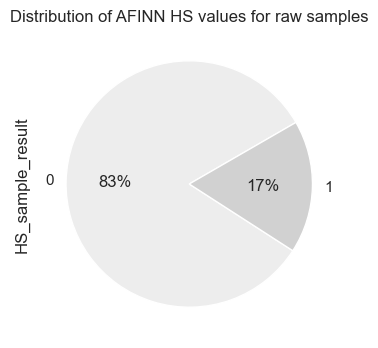

In [36]:
plt.figure(figsize=(4,4))
sns.set(style='white', palette='Greys', font_scale=1.0)

df['HS_sample_result'].value_counts().plot(kind='pie', 
                                          figsize=(4, 4),
                                          autopct='%1.0f%%',
                                          startangle=30, 
                                          title='Distribution of AFINN HS values for raw samples')

In [37]:
# create panda dataframe for results
df_AFINN_HSbinary_results = pd.DataFrame({'sample':df['sample'], 'HSbinary':df['HSbinary'], 'prediction':df['HS_sample_result']})
df_AFINN_HSbinary_results

,sample,HSbinary,prediction
0,- - opetustilanteisiin,0,0
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",0,0
2,= Minulle on tullut Playboy vuodesta 1972 läh...,0,0
3,=) (Juuri sellaiset joita suomessa myydään ha...,0,0
4,=) kristiina ja anna jatkoon! =),0,0
...,...,...,...
16003,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,0,0
16004,😠👉👩‍💼,0,0
16005,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,0,0
16006,🤮😡,0,0


In [38]:
HSbinary = df_AFINN_HSbinary_results['HSbinary'].tolist()
predictions = df_AFINN_HSbinary_results['prediction'].tolist()

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['HS', 'not HS']

print(classification_report(HSbinary, predictions, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

          HS       0.83      0.95      0.89     11555
      not HS       0.81      0.51      0.62      4453

    accuracy                           0.83     16008
   macro avg       0.82      0.73      0.75     16008
weighted avg       0.83      0.83      0.81     16008



In [40]:
print(confusion_matrix(HSbinary, predictions))

[[11012   543]
 [ 2204  2249]]


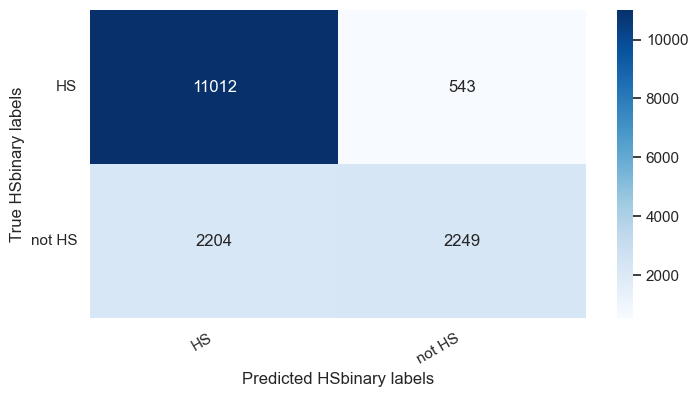

In [41]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True HSbinary labels')
    plt.xlabel('Predicted HSbinary labels');

cm = confusion_matrix(HSbinary, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [42]:
# metrics for binary classification
# --------------------------------------------
# The positive value is 1 and the negative value is 0.

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# calculate accuracy
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
total_accuracy = accuracy_score(HSbinary, predictions, normalize=True, sample_weight=None)
print('Accuracy  ', total_accuracy)

# calculate f1
# The formula for the F1 score is:    F1 = 2 * (precision * recall) / (precision + recall)
# 'binary': Only report results for the class specified by pos_label. 
# This is applicable only if targets (y_{true,pred}) are binary.
#total_f1 = f1_score(HSbinary, predictions, average='binary', labels=np.unique(predictions), zero_division=0)
total_f1 = f1_score(HSbinary, predictions, average='binary', sample_weight=None, zero_division=0)
print('F1  ', total_f1)

# calculate precision
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
total_precision = precision_score(HSbinary, predictions, average='binary', sample_weight=None, zero_division=0)
print('Precision  ', total_precision)

# calculate recall
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples.
#total_recall = recall_score(HSbinary, predictions, average='binary', labels=np.unique(predictions), sample_weight=None, zero_division=0)
total_recall = recall_score(HSbinary, predictions, average='binary', sample_weight=None, zero_division=0)
print('Recall  ', total_recall)

Accuracy   0.8283983008495752
F1   0.6208419599723947
Precision   0.8055157593123209
Recall   0.5050527734111835


In [43]:
#pip install pycm==4.0
from pycm import ConfusionMatrix

cm = ConfusionMatrix(actual_vector=HSbinary, predict_vector=predictions)
cm.classes

[0, 1]

In [44]:
cm.print_matrix()

Predict     0           1           
Actual
0           11012       543         

1           2204        2249        




In [45]:
cm.print_normalized_matrix()

Predict       0             1             
Actual
0             0.95301       0.04699       

1             0.49495       0.50505       




In [46]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.8284
F1 Macro                                                          0.75497
FPR Macro                                                         0.27097
Kappa                                                             0.51737
NPV Macro                                                         0.81937
Overall ACC                                                       0.8284
PPV Macro                                                         0.81937
SOA1(Landis & Koch)                                               Moderate
TPR Macro                                                         0.72903
Zero-one Loss                                                     2747

Class Statistics :

Classes                                                           0             1             
ACC(Accuracy)                                                     0.8284        0.8284        
AUC(Area under the ROC curve) 